# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

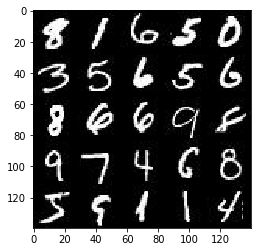

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

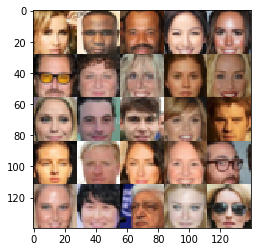

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=[])    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=.2, drop_rate=.1 ):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Leaky p.. (I added this)
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        # 4x4x256
    

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
       
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param reuse:
    :param alpha
    :return: The tensor output of the generator
    """
    
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        
        x0 = tf.layers.dense(z, 4*4*448)
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 4, 4, 448))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        
 
        # Reshape it to start the convolutional stack
        x1 = tf.layers.conv2d_transpose(x0, 224, 4, strides=1, padding='valid')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x448 now
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x224 now
        
        x3 = tf.layers.conv2d_transpose(x2, 56, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 32x32x3 now
        #logits = tf.reshape(logits, (None, 28, 28, out_channel_dim))
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,
                                              data_shape[3], alpha=.2)
    
    
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0 #For counting batches
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % 10 == 0:  #Print output every 10
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:   #Show example every 100
                    show_generator_output(sess, 25, input_z, data_shape[3], image_mode=data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4504... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 0.9303
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 1.5396
Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 0.2456... Generator Loss: 2.3729
Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 1.4623
Epoch 1/2... Discriminator Loss: 0.3284... Generator Loss: 2.0041
Epoch 1/2... Discriminator Loss: 0.3681... Generator Loss: 1.8902
Epoch 1/2... Discriminator Loss: 0.2698... Generator Loss: 2.0499


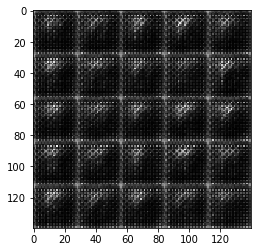

Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 1.6329
Epoch 1/2... Discriminator Loss: 0.3895... Generator Loss: 1.9915
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 1.2745
Epoch 1/2... Discriminator Loss: 0.6368... Generator Loss: 1.6318
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 1.7639
Epoch 1/2... Discriminator Loss: 0.3992... Generator Loss: 1.7333
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.1614
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 1.1968
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 0.5619... Generator Loss: 1.7643


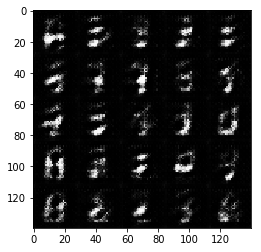

Epoch 1/2... Discriminator Loss: 0.6757... Generator Loss: 1.3954
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.3320
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.5510
Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 1.4334
Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 1.4854
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 1.1449


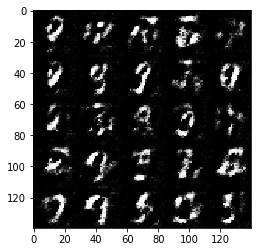

Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 1.9186
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 1.5998
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 1.0933
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 0.8327
Epoch 1/2... Discriminator Loss: 1.0844... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.1930
Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 0.8799
Epoch 1/2... Discriminator Loss: 0.7879... Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.4192


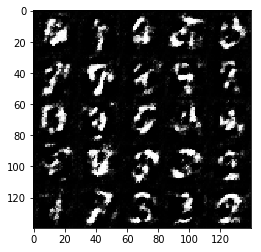

Epoch 1/2... Discriminator Loss: 0.7396... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 0.8761... Generator Loss: 1.5055
Epoch 1/2... Discriminator Loss: 0.7549... Generator Loss: 1.5735
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 1.8792
Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 0.7253... Generator Loss: 1.8566
Epoch 1/2... Discriminator Loss: 0.8278... Generator Loss: 2.0464
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.5440
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 2.1601
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.3076


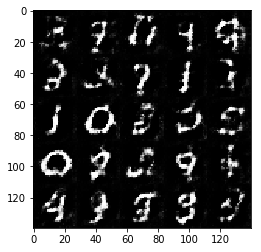

Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 2.5028
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 1.4222
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 0.9802
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 1.5695


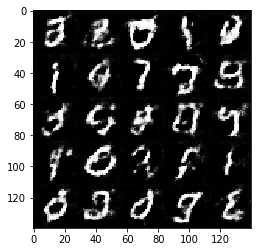

Epoch 2/2... Discriminator Loss: 0.8732... Generator Loss: 1.1278
Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 1.4673
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 1.1209
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.4526
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 1.3374
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 1.6573
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 0.9931
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.7206


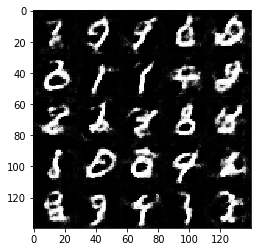

Epoch 2/2... Discriminator Loss: 0.8604... Generator Loss: 1.2365
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 1.3012
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 0.8639
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 1.8539
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 1.4682
Epoch 2/2... Discriminator Loss: 0.9901... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 1.6031
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.2275


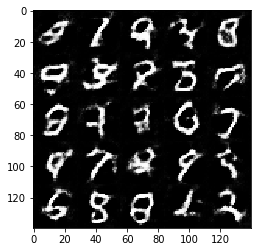

Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 1.3056
Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 0.9480... Generator Loss: 1.1902
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.0562
Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 0.9561
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 1.1336
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 1.6684


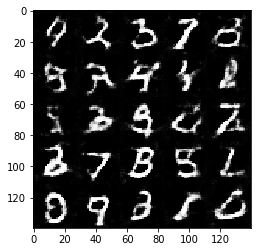

Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 0.9680
Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 1.2121
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 1.0622
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 0.9603... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.5336
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 0.9615


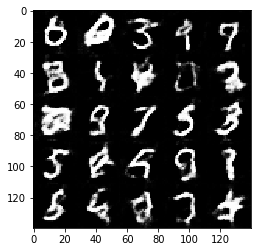

Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.0727
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 0.9531
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 1.2452
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 1.0109
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 0.6921


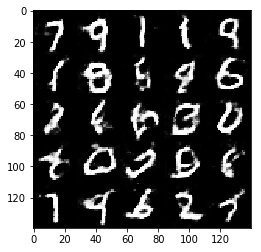

Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.0515
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 1.1229
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.0274
Epoch 2/2... Discriminator Loss: 1.2127... Generator Loss: 0.5036
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 0.9471


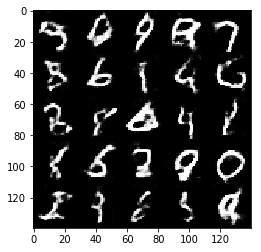

In [28]:
batch_size = 100
z_dim = 60
learning_rate = .0001
beta1 = .5

# In the paper they used  
# Weight initialization from Zero-centered normal with std of .02

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.4391
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 1.5580
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 0.2910... Generator Loss: 2.2818
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 1.8514
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 1.8355
Epoch 1/1... Discriminator Loss: 0.2873... Generator Loss: 1.9772


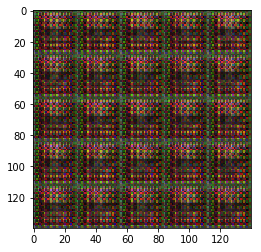

Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 2.1694
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 2.4952
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 2.7026
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 1.8385
Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 2.9860
Epoch 1/1... Discriminator Loss: 0.1691... Generator Loss: 2.7120
Epoch 1/1... Discriminator Loss: 0.1499... Generator Loss: 2.7420
Epoch 1/1... Discriminator Loss: 0.2679... Generator Loss: 1.8968
Epoch 1/1... Discriminator Loss: 0.1611... Generator Loss: 2.6631
Epoch 1/1... Discriminator Loss: 0.2500... Generator Loss: 2.1717


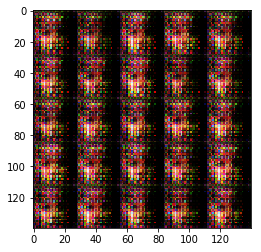

Epoch 1/1... Discriminator Loss: 0.1673... Generator Loss: 2.3448
Epoch 1/1... Discriminator Loss: 0.1710... Generator Loss: 2.5954
Epoch 1/1... Discriminator Loss: 0.3047... Generator Loss: 1.8495
Epoch 1/1... Discriminator Loss: 0.1471... Generator Loss: 2.6283
Epoch 1/1... Discriminator Loss: 0.0701... Generator Loss: 3.2898
Epoch 1/1... Discriminator Loss: 0.1948... Generator Loss: 2.8086
Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 2.4096
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 2.2294
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 2.8643
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 1.3017


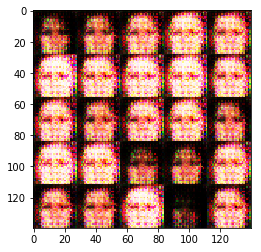

Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 2.4206
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 2.4519
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 4.2416
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.1961
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 3.8040
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 1.9674
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 2.4428
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 1.4422


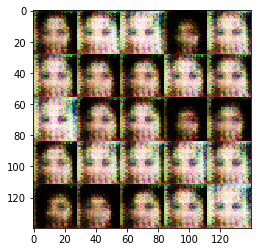

Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 1.8851
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 3.0405
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 5.0321
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 1.6608
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 1.6952
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 2.0769
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.0933


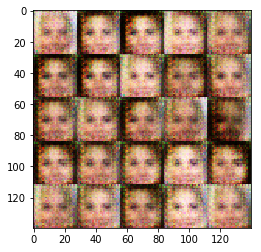

Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.3797
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.5709
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.8093
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.9619
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 1.7096
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.4364


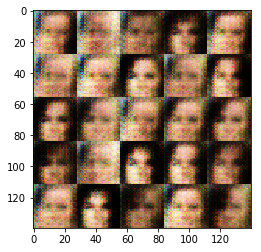

Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 2.0385
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.5214
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.6037
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 1.4801


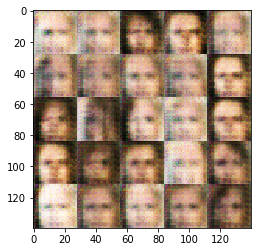

Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.3905
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.4224
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8715


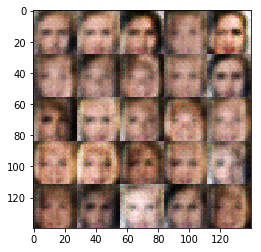

Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.3219
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.1731
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.5173
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8487


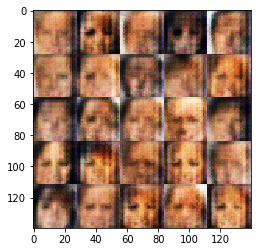

Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.5721
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.2066


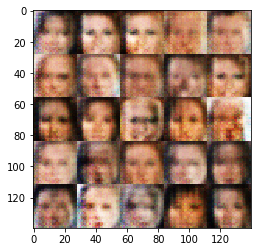

Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.4379
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.6505
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 1.6355
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.8899


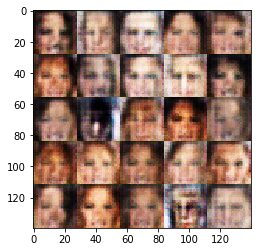

Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.2760
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.5365
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.2239


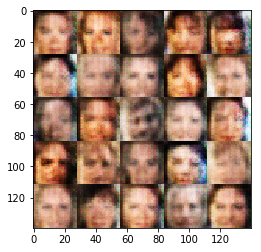

Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9168


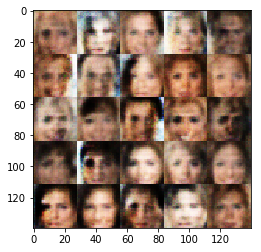

Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.4122
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.5850
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7485


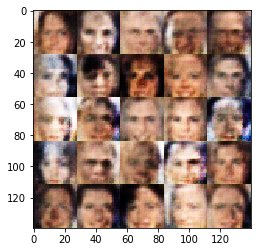

Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.2894


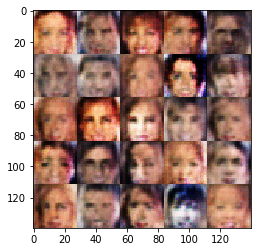

Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.3513
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.4180
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.7377


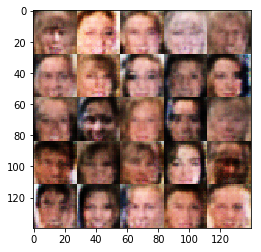

Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 2.0581
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.5499
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.4858


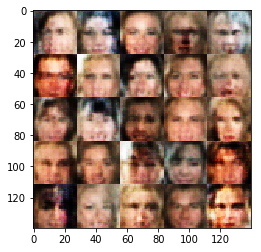

Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.2791
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.4707
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.2502


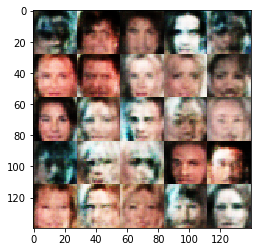

Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.6622
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.7957
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.1351


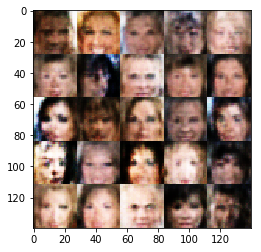

Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.5365
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.4880


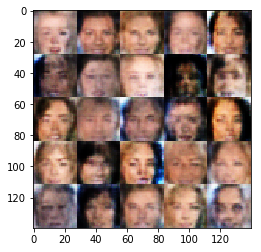

Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.1304


In [27]:
batch_size = 100
z_dim = 60
learning_rate = .0001
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.